In [115]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [36]:
tracks = pd.read_csv('tracks.txt', delim_whitespace=True)

tracks['dx'] = np.sqrt(pow(tracks['x_end']-tracks['x_start'], 2) + 
                       pow(tracks['y_end']-tracks['y_start'], 2) +
                       pow(tracks['z_end']-tracks['z_start'], 2))

tracks['x'] = (tracks['x_end']-tracks['x_start'])/2
tracks['y'] = (tracks['y_end']-tracks['y_start'])/2
tracks['z'] = (tracks['z_end']-tracks['z_start'])/2

tracks['dE'] = np.abs(tracks['dE']*1e3)
tracks['dEdx'] = tracks['dE']/tracks['dx']
# tracks = tracks.drop(columns=['x_start','y_start','z_start','x_end','y_end','z_end'])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ttracks = torch.tensor(tracks.values).to(device)

ix = tracks.columns.get_loc("x")
iy = tracks.columns.get_loc("y")
idE = tracks.columns.get_loc("dE")
idx = tracks.columns.get_loc("dx")
idEdx = tracks.columns.get_loc("dEdx")
iz = tracks.columns.get_loc("z")
iNElectrons = iz+1
iDriftTime =iz+2
iLDiff = iz+3
iTDiff = iz+4

In [101]:

class IonizationElectrons(torch.nn.Module):
    def __init__(self):
        """
        """
        self._MeVToElectrons = 4.237e+04
        self._alpha   = 0.847
        self._beta    = 0.2061
        self._vdrift  = 0.153812 # cm/us
        self._lifetime = 10e3 # us
        self._tpcPlaneZ = 0
        self._lDiff = 6.2e-6 # cm^2/us
        self._tDiff = 16.3e-6 # cm^2/us

        super(IonizationElectrons, self).__init__()

        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """

        add_column = torch.nn.ZeroPad2d((0, 1, 0, 0))
        x = add_column(x)
        x = add_column(x)
        x = add_column(x)
        x = add_column(x)

        recomb = torch.log(self._alpha + self._beta * x[:,idEdx]) / (self._beta * x[:,idEdx])
        recomb = torch.where(recomb<=0, torch.zeros_like(recomb), recomb)
        recomb = torch.where(torch.isnan(recomb), torch.zeros_like(recomb), recomb)

        driftDistance = torch.abs(x[:,iz] - self._tpcPlaneZ)
        driftTime = driftDistance / self._vdrift
        lifetime = torch.exp(-driftTime / self._lifetime)

        x[:,iNElectrons] = self._MeVToElectrons * x[:,idE] * recomb * lifetime
        x[:,iDriftTime] = driftTime
        x[:,iLDiff] = torch.sqrt(driftTime) * self._lDiff
        x[:,iTDiff] = torch.sqrt(driftTime) * self._tDiff / self._vdrift + x[:,iDriftTime] 

        return x

In [102]:
ionizationElectrons = IonizationElectrons()
driftedTracks = ionizationElectrons(ttracks)

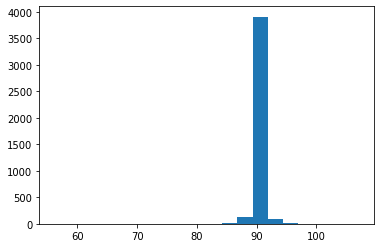

In [123]:
_ = plt.hist(driftedTracks[:,3].cpu().numpy(), bins=20)